In [40]:
import sys
sys.path.append('D:/UNESP/EngMec-UNESP/')
import frankenstein as fk

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import ZebraLib as zb
import uncertainties.unumpy as un

D1=0.0385; A1 = np.pi*(D1**2)/4
Dt=0.0257; At = np.pi*(Dt**2)/4
beta = Dt/D1

def f_distrib(delta_h):

    Vm = calc_vazão(delta_h)[2]
    hl = hl_(delta_h)

    D1=0.0385 #m
    L = 5     #m
    return (2*D1*hl)/(L*Vm**2)

def f_blassius(delta_h):
    Re = calc_vazão(delta_h)[1]
    return 0.316/(Re**0.25)

def calc_rugosidade(delta_h):

    Re = calc_vazão(delta_h)[1]

    def rugosidade(Rug, args):
        f = f_blassius(delta_h)
        #f = f_distrib(delta_h)

        A = ((Rug/3.7)**1.11) + (6.9/Re)
        return 1/np.sqrt(f) + 1.8*np.log10(A)
    Rug, it, res = zb.robustNewton(rugosidade, np.array([3e-4]), args=Re)
    return Rug

def hl_(delta_h):
    '''
    Calcula a perda de carga hl dado  
    diferença de H do tubo em U [cm] com água.
    '''
    delta_P = fk.rho_agua*fk.g*(delta_h/100)
    return delta_P/fk.rho_ar

def calc_vazão(delta_h):
    '''
    Calcula a vazão em massa, número de Reynouds e velocidade. Obs: delta_h [cm]
    '''
    D1=0.0385; A1 = np.pi*(D1**2)/4
    Dt=0.0257; At = np.pi*(Dt**2)/4
    beta = Dt/D1

    def residuo_Re(Re, delta_h):
        delta_P = fk.rho_agua*fk.g*(delta_h/100)

        C = 0.5959 + (0.0312*(beta**2.1)) - (0.184*beta**8) + ((91.71*beta**2.5)/(Re**0.75))
        K = C/np.sqrt(1 - beta**4)
        return ((fk.rho_ar*Re*fk.mi*A1)/D1) - (K*At*np.sqrt(2*fk.rho_ar*delta_P))
        
    Re, it, res = (zb.robustNewton(residuo_Re, np.array([1e6]), args=delta_h))
    
    dot_m = (fk.rho_ar*Re*fk.mi*A1)/D1
    velocidade = (Re*fk.mi)/D1
    return float(dot_m), float(Re), float(velocidade) #kg/s, adim, m/s

def vazão_from_dataframe(df_, key=0):
    '''
    Calcula a vazão em massa, número de Reynouds e velocidade e retorna em um Dataframe. Obs: delta_h [cm]
    '''
    arr_po = np.zeros((df_.shape[0], df_.shape[1]-2))
    for j in range(arr_po.shape[1]):
        col_nome = ['PO_TL', 'PO_TR'][j]
        for i in range(arr_po.shape[0]):
            delta_h = df_[col_nome].values[i]
            arr_po[i, j] = calc_vazão(delta_h)[key] #[0]kg/s, [1]adim, [2]m/s
            
    return pd.DataFrame(arr_po, columns=['PO_TL', 'PO_TR'])

df = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. Mec Flu II/Lab 3 - Perda de carga/dados3.xlsx', 
                    sheet_name='df_data')

dfr = df[0:15:4]
dfr

,PO_TL,TL,PO_TR,TR
0,6.4,1.9,2.3,2.7
4,13.6,3.6,6.5,7.2
8,17.6,4.3,8.0,8.9
12,18.7,4.5,8.6,9.7


In [12]:
df_ = dfr; key=1

arr_po = np.zeros((df_.shape[0], df_.shape[1]))
for j in range(arr_po.shape[1]):
    col_nome = ['PO_TL', 'PO_TR', 'TL', 'TR'][j]
    fun = [calc_vazão, calc_vazão, hl, hl]
    for i in range(arr_po.shape[0]):

        delta_h = df_[col_nome].values[i]
        try:
            value = fun[j](delta_h)[key]
        except:
            value = fun[j](delta_h)

        arr_po[i, j] = value #[0]kg/s, [1]adim, [2]m/s
        
df1 = pd.DataFrame(arr_po, columns=['key_TL', 'key_TR', 'h_TL', 'h_TR'])
df1

,key_TL,key_TR,h_TL,h_TR
0,21350.889278,12975.858923,154.859025,220.062825
1,30894.658717,21513.333229,293.417100,586.834200
2,35071.422566,23813.883712,350.470425,725.392275
3,36133.845122,24672.558253,366.771375,790.596075


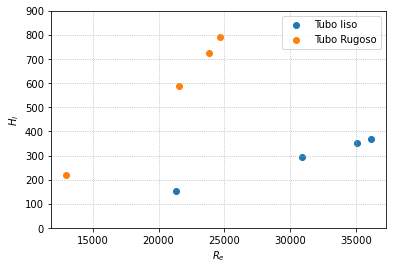

In [22]:
fig, ax = plt.subplots()
ax.set(xlabel=r'$R_e$', ylabel=r'$H_l$', ylim=(0,900))

ax.scatter(df1['key_TL'].values, df1['h_TL'].values, label='Tubo liso')
ax.scatter(df1['key_TR'].values, df1['h_TR'].values, label='Tubo Rugoso')

ax.legend()
ax.grid(ls='dotted')

fig.savefig('h_Re.pdf', bbox_inches='tight')

In [30]:
dfr

,PO_TL,TL,PO_TR,TR
0,6.4,1.9,2.3,2.7
4,13.6,3.6,6.5,7.2
8,17.6,4.3,8.0,8.9
12,18.7,4.5,8.6,9.7


In [52]:
df_ = dfr; key=1

arr_po = np.zeros((df_.shape[0], df_.shape[1]))
for j in range(arr_po.shape[1]):
    col_nome = ['PO_TL', 'PO_TR', 'TL', 'TR'][j]
    fun = [calc_rugosidade, calc_rugosidade, f_distrib, f_distrib]
    for i in range(arr_po.shape[0]):

        delta_h = df_[col_nome].values[i]
        value = fun[j](delta_h)

        arr_po[i, j] = value #[0]kg/s, [1]adim, [2]m/s
        
df1 = pd.DataFrame(arr_po, columns=['ed_TL', 'ed_TR', 'f_TL', 'f_TR'])
df1

,ed_TL,ed_TR,f_TL,f_TR
0,0.062207,0.057622,0.077951,0.078829
1,0.064672,0.062265,0.079480,0.080825
2,0.065373,0.063007,0.079854,0.081180
3,0.065529,0.063253,0.079946,0.081317


In [44]:
print(df1.to_latex(index=0))

\begin{tabular}{rrrr}
\toprule
   ed\_TL &    ed\_TR &     f\_TL &     f\_TR \\
\midrule
0.062207 & 0.057622 & 0.077951 & 0.078829 \\
0.064672 & 0.062265 & 0.079480 & 0.080825 \\
0.065373 & 0.063007 & 0.079854 & 0.081180 \\
0.065529 & 0.063253 & 0.079946 & 0.081317 \\
\bottomrule
\end{tabular}



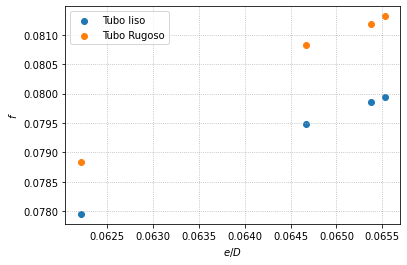

In [47]:
fig, ax = plt.subplots()
ax.set(xlabel=r'$e/D$', ylabel=r'$f$')

ax.scatter(df1['ed_TL'].values, df1['f_TL'].values, label='Tubo liso')
ax.scatter(df1['ed_TL'].values, df1['f_TR'].values, label='Tubo Rugoso')

ax.legend()
ax.grid(ls='dotted')

fig.savefig('f_ed.pdf', bbox_inches='tight')

In [48]:
df_ = dfr

arr_po = np.zeros((df_.shape[0], df_.shape[1]))
for j in range(arr_po.shape[1]):
    col_nome = ['PO_TL', 'PO_TR', 'TL', 'TR'][j]
    fun = [f_blassius, f_blassius, f_distrib, f_distrib]
    for i in range(arr_po.shape[0]):

        delta_h = df_[col_nome].values[i]
        value = fun[j](delta_h)

        arr_po[i, j] = value #[0]kg/s, [1]adim, [2]m/s
        
df2 = pd.DataFrame(arr_po, columns=['fb_TL', 'fb_TR', 'fd_TL', 'fd_TR'])
df2

,fb_TL,fb_TR,fd_TL,fd_TR
0,0.026142,0.029608,0.077951,0.078829
1,0.023835,0.026092,0.079480,0.080825
2,0.023091,0.025438,0.079854,0.081180
3,0.022920,0.025214,0.079946,0.081317


In [49]:
print(df2.to_latex(index=0))

\begin{tabular}{rrrr}
\toprule
   fb\_TL &    fb\_TR &    fd\_TL &    fd\_TR \\
\midrule
0.026142 & 0.029608 & 0.077951 & 0.078829 \\
0.023835 & 0.026092 & 0.079480 & 0.080825 \\
0.023091 & 0.025438 & 0.079854 & 0.081180 \\
0.022920 & 0.025214 & 0.079946 & 0.081317 \\
\bottomrule
\end{tabular}



In [60]:
df_ = dfr

arr_po = np.zeros((df_.shape[0], df_.shape[1]))
for j in range(arr_po.shape[1]):
    col_nome = ['PO_TL', 'PO_TR', 'TL', 'TR'][j]
    fun = [calc_rugosidade, calc_rugosidade, f_blassius, f_blassius]
    for i in range(arr_po.shape[0]):

        delta_h = df_[col_nome].values[i]
        value = fun[j](delta_h)

        arr_po[i, j] = value #[0]kg/s, [1]adim, [2]m/s
        
df2 = pd.DataFrame(arr_po, columns=['ed_TL', 'ed_TR', 'fb_TL', 'fb_TR'])
df2

,ed_TL,ed_TR,fb_TL,fb_TR
0,0.062207,0.057622,0.030299,0.029038
1,0.064672,0.062265,0.028041,0.025768
2,0.065373,0.063007,0.027441,0.025108
3,0.065529,0.063253,0.027290,0.024844


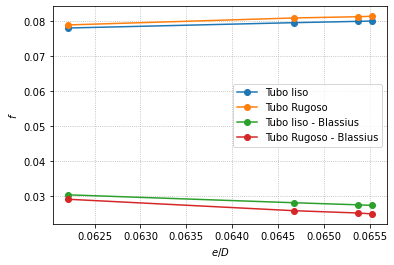

In [65]:

fig, ax = plt.subplots()
ax.set(xlabel=r'$e/D$', ylabel=r'$f$')

ax.plot(df1['ed_TL'].values, df1['f_TL'].values,  marker='o', label='Tubo liso')
ax.plot(df1['ed_TL'].values, df1['f_TR'].values,  marker='o', label='Tubo Rugoso')
ax.plot(df2['ed_TL'].values, df2['fb_TL'].values, marker='o', label='Tubo liso - Blassius')
ax.plot(df2['ed_TL'].values, df2['fb_TR'].values, marker='o', label='Tubo Rugoso - Blassius')

ax.legend()
ax.grid(ls='dotted')

fig.savefig('fb_ed.pdf', bbox_inches='tight')